In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
df1=pd.read_excel('/content/2011him.xlsx')
df2=pd.read_excel('/content/2012him (1).xlsx')
df3=pd.read_excel('/content/2013him.xlsx')
df4=pd.read_excel('/content/2014him.xlsx')
df5=pd.read_excel('/content/2015him.xlsx')
df6=pd.read_excel('/content/2016him.xlsx')
df7=pd.read_excel('/content/2017him.xlsx')

In [ ]:
df2=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=0)
df2.head()

,1,shimla
0,Jan.,191790
1,Feb.,181459
2,Mar.,211635
3,Apr.,408219
4,May,402197


In [ ]:
df2.keys()

Index([1, 'shimla'], dtype='object')

In [ ]:
start_date = pd.to_datetime('2011-01-01')

# Create a date-time range starting from the specified month, incrementing by one month
date_range = pd.date_range(start=start_date, periods=len(df2), freq='M')

# Set the date-time range as the index for the DataFrame
df2.index = date_range
df2.head()

,1,shimla
2011-01-31,Jan.,191790
2011-02-28,Feb.,181459
2011-03-31,Mar.,211635
2011-04-30,Apr.,408219
2011-05-31,May,402197


In [ ]:

df2=df2.rename(columns={'shimla':'footfall'})
df2.head()

,1,footfall
2011-01-31,Jan.,191790
2011-02-28,Feb.,181459
2011-03-31,Mar.,211635
2011-04-30,Apr.,408219
2011-05-31,May,402197


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2011-01-31 to 2017-12-31
Freq: M
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   1         84 non-null     object
 1   footfall  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


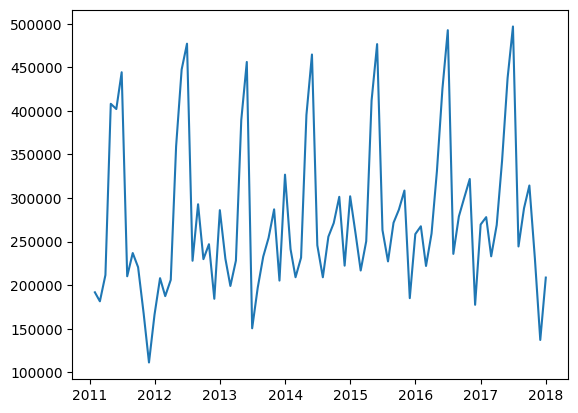

In [ ]:
plt.plot(df2.index,df2['footfall'])
plt.show()

In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(df2['footfall'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [ ]:
adfuller_test(df2['footfall'])

ADF Test Statistic : -1.859558411623371
p-value : 0.3513185798724803
#Lags Used : 11
Number of Observations Used : 72
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**The data is non stationary, we have to make it stationary**

In [ ]:
#differencing

df2['footfallDifference']=df2['footfall']-df2['footfall'].shift(6)

In [93]:
data=df2.to_excel('shimlaFootfall.xlsx',index=True)

In [ ]:
df2.head()

,1,footfall,footfallDifference
2011-01-31,Jan.,191790,NaN
2011-02-28,Feb.,181459,NaN
2011-03-31,Mar.,211635,NaN
2011-04-30,Apr.,408219,NaN
2011-05-31,May,402197,NaN


In [ ]:
adfuller_test(df2['footfallDifference'].dropna())

ADF Test Statistic : -17.582345834467585
p-value : 4.001489376838925e-30
#Lags Used : 5
Number of Observations Used : 72
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


**we try to make the p value zero**

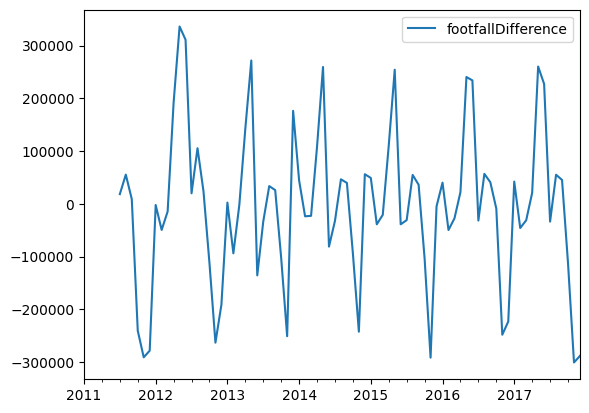

In [ ]:
df2['footfallDifference'].plot()

plt.legend()

**Auto correlation part, to know how the lagging part is correlated with the present part**

In [ ]:
df2.isnull().sum()

1                     0
footfall              0
footfallDifference    6
dtype: int64

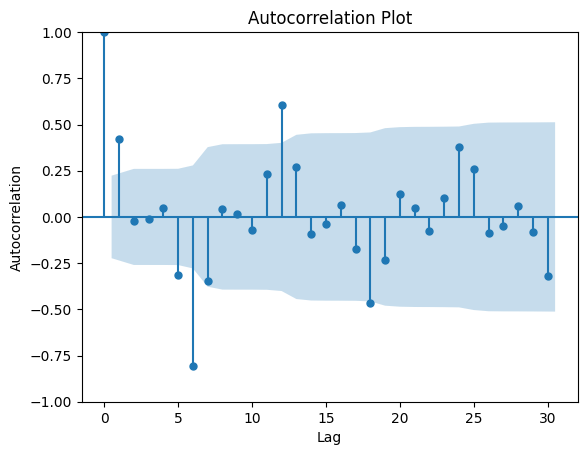

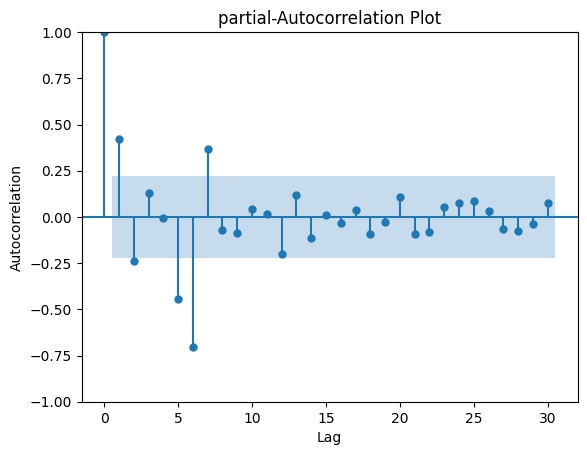

In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df2['footfallDifference'].iloc[7:], lags=30)  # Adjust 'lags' as needed
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

sm.graphics.tsa.plot_pacf(df2['footfallDifference'].iloc[7:],lags=30)
plt.title('partial-Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

**from the ACF plot we obtain the q value as 12,  and p value from the PACF plot, as 7**

#For non seasonal models, Seasonal ARIMA works well.

In [ ]:
df2.shape

(84, 3)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [91]:
import statsmodels.api as sm
model=sm.tsa.ARIMA(df2['footfall'][:60],order=(7,1,12))
model_fit=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

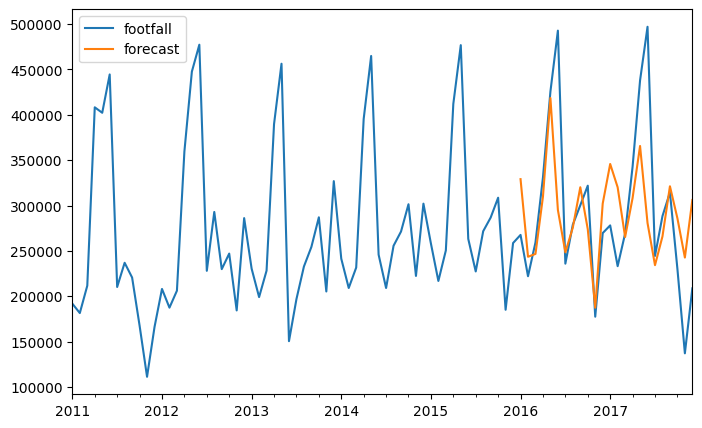

In [92]:
df2['forecast']=model_fit.predict(start=60,end=len(df2)-1,dynamic=True)
df2[['footfall','forecast']].plot(figsize=(8,5)) #d=1

In [ ]:
forecast = model_fit.forecast(steps=10)

In [ ]:
forecast.shape

(10,)

<Axes: >

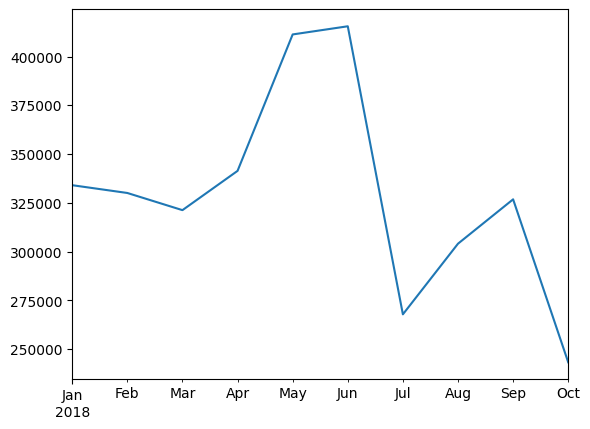

In [ ]:
forecast.plot()

<Axes: >

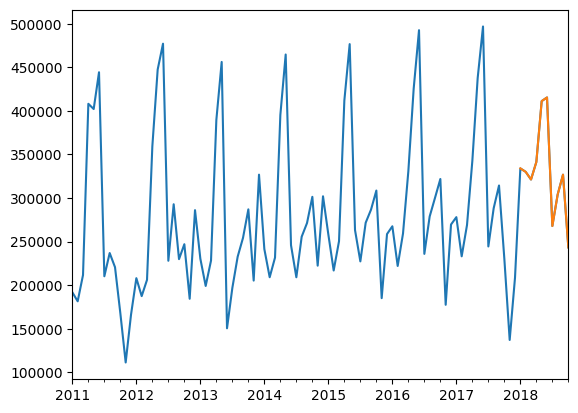

In [ ]:
df_new=pd.concat([df2['footfall'],forecast])
df_new.plot()
forecast.plot() #d=1

In [ ]:
import statsmodels.api as sm

best_arima_model = sm.tsa.statespace.SARIMAX(df2['footfall'],order=(7, 1, 12), seasonal_order=(7,1,12,13))
best_arima_model_fit = best_arima_model.fit()

df2['forecast_sarima']=best_arima_model_fit.predict(start=60,end=len(df2)-1,dynamic=True)
df2[['footfall','forecast_sarima']].plot(figsize=(12,8))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: ignored